# Dataset Statistics for Compound Gene Sentences

This notebook is designed to show statistics on the data extracted from pubmed. The following cells below here are needed to set up the environment.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from collections import Counter
from itertools import product
import os
import pickle
import sys

sys.path.append(os.path.abspath('../../../modules'))

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import seaborn as sns
from tqdm import tqdm_notebook

sns.set(rc={'figure.figsize':(12,6), "font.size":17})

In [2]:
#Set up the environment
username = "danich1"
password = "snorkel"
dbname = "pubmeddb"

#Path subject to change for different os
database_str = "postgresql+psycopg2://{}:{}@/{}?host=/var/run/postgresql".format(username, password, dbname)
os.environ['SNORKELDB'] = database_str

from snorkel import SnorkelSession
session = SnorkelSession()

In [3]:
from snorkel.models import candidate_subclass, Candidate
CompoundGene = candidate_subclass('CompoundGene', ['Compound', 'Gene'])

In [4]:
from utils.notebook_utils.dataframe_helper import write_candidates_to_excel, make_sentence_df

# Read Full Sentence Table

The cells below will read every sentence that contains a gene and compound entity from the sentence table in our postgres database. For time sake majority of the data has already been processed and save as files mentioned below.

In [ ]:
sql= '''
select id as sentence_id, text, (
    char_length(regexp_replace(CAST(words AS TEXT), '[\u0080-\u00ff]', '', 'g')) - 
    char_length(regexp_replace(regexp_replace(CAST(words AS TEXT), '[\u0080-\u00ff]', '', 'g'), ',', '','g'))
) as sen_length, entity_types 
from sentence 
where entity_types::text like '%%Compound%%' or entity_types::text like '%%Gene%%';
'''
sentence_df = pd.read_sql(sql, database_str)
sentence_df.head(2)

In [ ]:
entity_data = []
tagging_error_ids = set({})

#skip tagging error
skip_tag_error = False
for index, row in tqdm_notebook(sentence_df.iterrows()):
    
    #create dictionay for mapping entity types
    entity_mapper = {"sentence_id": row['sentence_id']}
    
    #Keep track of previous entity
    previous_entity = 'o'
    
    #For all entitys in a given sentence decide what is tagged
    for entity in row['entity_types']:
        entity = entity.lower()

        #Non-O tag
        if entity != 'o' and previous_entity =='o':
            #If entity not seen before instanciate it
            if entity not in entity_mapper:
                entity_mapper[entity] =0
            entity_mapper[entity] += 1

        # If previous tag was non-O and the current tag does not equal previous
        # Then tagging error. e.x. Disease, Gene, Disease instead of Disease, O, Disease
        elif entity != previous_entity and entity != 'o':
            tagging_error_ids.add(row['sentence_id'])
            skip_tag_error = True
            break

        previous_entity = entity
    
    # Do not add errors to dataframe
    # They will be thrown out
    if not skip_tag_error:
        entity_data.append(entity_mapper)

    skip_tag_error=False
    
entity_stats_df = pd.DataFrame.from_dict(entity_data).fillna(0)
entity_stats_df.head(2)

In [ ]:
tagging_error_df = pd.Series(sorted(list(tagging_error_ids)))
tagging_error_df.to_csv("data/tagging_error_ids.tsv.xz", sep="\t",  index=False, compression="xz")
tagging_error_df.head(2)

In [ ]:
print(
    "Total Number of IOB Tagging Errors: {}. Percentage of sentences affected: {:.2f}".format(
        tagging_error_df.shape[0],
        100*tagging_error_df.shape[0]/sentence_df.shape[0]
    )
)

In [ ]:
header = ["sentence_id", "text", "sen_length"]
sentence_df[header].to_csv("data/sentence_stats.tsv.xz", sep="\t", index=False, compression="xz")
entity_stats_df.to_csv("data/entity_stats.tsv.xz", sep="\t",  index=False, compression="xz")

# Sentence Counts and Statistics

Below is the block of code that contains information about the full distribution of sentences tied to each candidate pair. Multiple sentences can contain more than one co-occuring pair, which results in some sentences being counted more than once. For example
```
To assess the importance of the consensus amino acid sequence in [elf-4a G] for [atp G] binding, we mutated the consensus amino-proximal [glycine C] and [lysine C] to isoleucine and asparagine, respectively.
```

In this sentence there are multiple mentions of genes and compounds, where some compounds are artificial proteins. 

## Load and Merge DataFrames

In [5]:
entity_level_df = pd.read_csv("../compound_gene_pairs_binds.csv")
entity_level_df.head(2)

,entrez_gene_id,gene_symbol,drugbank_id,name,sources,hetionet,n_sentences,has_sentence,partition_rank,split
0,1,A1BG,DB00117,L-Histidine,NaN,0,1,1,0.37753,6
1,1,A1BG,DB00143,Glutathione,NaN,0,1,1,0.30352,6


In [6]:
entity_stats_df = pd.read_table("data/entity_stats.tsv.xz")
entity_stats_df.head(2)

,compound,disease,gene,sentence_id
0,0.0,1.0,1.0,50851796
1,0.0,0.0,1.0,50851806


In [7]:
sentence_count_df = pd.read_table("data/sentence_stats.tsv.xz")
sentence_count_df.head(2)

,sentence_id,text,sen_length
0,50851796,In this study we aimed to characterize the vir...,28
1,50851806,HLA-A2 tetramers were used to identify HBV-spe...,18


In [8]:
sentence_sql = '''
select cand_id, "Gene_cid" as entrez_gene_id, "Compound_cid" as drugbank_id, sentence_id from (
    select compound_gene.id as "cand_id", compound_gene."Compound_id",
    compound_gene."Gene_cid", compound_gene."Compound_cid", candidate.split from compound_gene 
    inner join candidate on compound_gene.id=candidate.id 
    where split={}
) as candidate_splits inner join span on candidate_splits."Compound_id"=span.id;
'''

In [9]:
train_candidate_df = pd.read_sql(sentence_sql.format(6), database_str)
train_candidate_df.head(2)

,cand_id,entrez_gene_id,drugbank_id,sentence_id
0,50588,1769,DB01164,155110
1,50842,2688,DB09099,685805


In [10]:
dev_candidate_df = pd.read_sql(sentence_sql.format(7), database_str)
test_candidate_df = pd.read_sql(sentence_sql.format(8), database_str)

In [11]:
clean_up_df = lambda x: (
        entity_stats_df
        .merge(sentence_count_df, on="sentence_id")
        .merge(x, on="sentence_id")
        .rename(index=str, columns={
            "disease":"disease_mention_count", 
            "gene":"gene_mention_count", 
            "compound":"compound_mention_count",
            "cand_id": "candidate_id"
        })
    )

In [12]:
train_candidate_df = clean_up_df(train_candidate_df)
train_candidate_df.head(2)

,compound_mention_count,disease_mention_count,gene_mention_count,sentence_id,text,sen_length,candidate_id,entrez_gene_id,drugbank_id
0,3.0,0.0,1.0,50850873,RNAi-mediated MR silencing led to a decrease i...,41,14937760,2538,DB11280
1,3.0,0.0,1.0,50850873,RNAi-mediated MR silencing led to a decrease i...,41,14937755,2538,DB04173


In [13]:
dev_candidate_df = clean_up_df(dev_candidate_df)
test_candidate_df = clean_up_df(test_candidate_df)

In [14]:
training_set_df = (
    entity_level_df
    .query("split==6&has_sentence==1")
    .merge(
        train_candidate_df.astype({"entrez_gene_id":int}), 
        on=["drugbank_id", "entrez_gene_id"]
    )
)
training_set_df.head(2)

,entrez_gene_id,gene_symbol,drugbank_id,name,sources,hetionet,n_sentences,has_sentence,partition_rank,split,compound_mention_count,disease_mention_count,gene_mention_count,sentence_id,text,sen_length,candidate_id
0,1,A1BG,DB00117,L-Histidine,NaN,0,1,1,0.37753,6,1.0,0.0,10.0,94389805,"Thus, as the assessment of protein glycosylati...",114,33517095
1,1,A1BG,DB00143,Glutathione,NaN,0,1,1,0.30352,6,1.0,1.0,2.0,83523801,Similar observations were made in T98 glioma c...,34,28913100


In [15]:
dev_set_df = (
    entity_level_df
    .query("split==7&has_sentence==1")
    .merge(
        dev_candidate_df.astype({"entrez_gene_id":int}), 
        on=["drugbank_id", "entrez_gene_id"]
    )
)

test_set_df = (
    entity_level_df
    .query("split==8&has_sentence==1")
    .merge(
        test_candidate_df.astype({"entrez_gene_id":int}), 
        on=["drugbank_id", "entrez_gene_id"]
    )
)

In [16]:
total_candidates_df = (
    training_set_df
    .append(dev_set_df)
    .append(test_set_df)
)

In [17]:
dev_candidates = (
    session
    .query(CompoundGene)
    .filter(
        CompoundGene.id.in_(
            total_candidates_df
            .query("split==7")
            .sample(10000, random_state=100)
            .candidate_id
            .tolist()
        )
    )
    .all()
)
dev_df = make_sentence_df(dev_candidates)
dev_df.head(2)

HBox(children=(IntProgress(value=0, max=10000), HTML(value='')))

,candidate_id,compound,gene,drugbank_id,entrez_gene_id,sentence
0,50527,sodium dodecylsulphate,Fab-fragments,DB00815,2187,"the effect of nacl , ( nh4 ) 2so4 , ~~[[1 sodi..."
1,51441,cortisone,GH,DB01380,2688,the glycemic response to iv glucose was simila...


In [18]:
test_candidates = (
    session
    .query(CompoundGene)
    .filter(
        CompoundGene.id.in_(
            total_candidates_df
            .query("split==8")
            .sample(10000, random_state=100)
            .candidate_id
            .tolist()
        )
    )
    .all()
)
test_df = make_sentence_df(test_candidates)
test_df.head(2)

HBox(children=(IntProgress(value=0, max=10000), HTML(value='')))

,candidate_id,compound,gene,drugbank_id,entrez_gene_id,sentence
0,50759,arginine,C5a,DB04027,728,"the spasmogenic , tachyphylactic , and vascula..."
1,51021,bicarbonate,transferrin,DB01390,7018,in an attempt to imitate conditions in the inf...


In [ ]:
write_candidates_to_excel(dev_df, "data/sentence_labels_dev.xlsx")
write_candidates_to_excel(test_df, "data/sentence_labels_test.xlsx")

## Distribution of Sentence Length

/home/danich1/anaconda2/envs/snorkeling/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


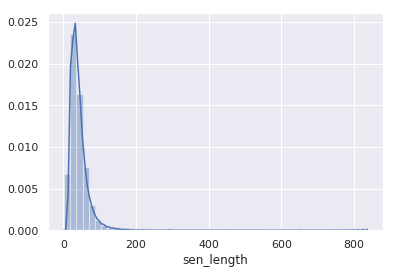

In [19]:
sns.distplot(total_candidates_df["sen_length"], rug=False)

In [20]:
total_candidates_df["sen_length"].describe().astype(int)

count    2417701
mean          42
std           29
min            3
25%           26
50%           36
75%           50
max          834
Name: sen_length, dtype: int64

Something seems fishy about this distribution. The number of words (tokens) for a given sentence is in the thousands range. Intuitively, that doesn't make sense, since the average number of words for a given sentence is 42. Possible reason for this abnormality is a parsing error. Lets take a look at this 834 word sentence.

In [21]:
total_candidates_df.query("sen_length==834").iloc[0]["text"]

"This issue focuses on the following selection of drugs: Abiraterone acetate, acyline, adalimumab, adenosine triphosphate, AEE-788, AIDSVAX gp120 B/B, AK-602, alefacept, alemtuzumab, alendronic acid sodium salt, alicaforsen sodium, alprazolam, amdoxovir, AMG-162, aminolevulinic acid hydrochloride, aminolevulinic acid methyl ester, aminophylline hydrate, anakinra, anecortave acetate, anti-CTLA-4 MAb, APC-8015, aripiprazole, aspirin, atazanavir sulfate, atomoxetine hydrochloride, atorvastatin calcium, atrasentan, AVE-5883, AZD-2171; Betamethasone dipropionate, bevacizumab, bimatoprost, biphasic human insulin (prb), bortezomib, BR-A-657, BRL-55730, budesonide, busulfan; Calcipotriol, calcipotriol/betamethasone dipropionate, calcium folinate, capecitabine, capravirine, carmustine, caspofungin acetate, cefdinir, certolizumab pegol, CG-53135, chlorambucil, ciclesonide, ciclosporin, cisplatin, clofarabine, clopidogrel hydrogensulfate, clozapine, co-trimoxazole, CP-122721, creatine, CY-2301, c

The above sentence shows that a long list of drugs that a issue will cover. This isn't helpful in our case, because we want to look at sentences that contain compounds and diseases; therefore, we should remove sentences of this nature by defining a cutoff score of 83 or less words.

/home/danich1/anaconda2/envs/snorkeling/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


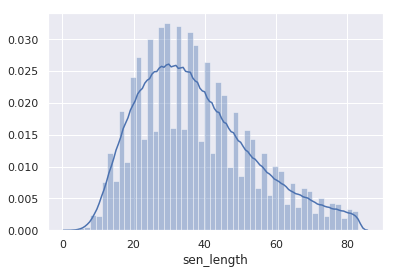

In [22]:
sns.distplot(total_candidates_df.query("sen_length < 83+1")["sen_length"], rug=False)

In [23]:
total_candidates_df.query("sen_length < 83+1")["sen_length"].describe().astype(int)

count    2283535
mean          37
std           16
min            3
25%           25
50%           35
75%           47
max           83
Name: sen_length, dtype: int64

This distribution looks a bit more reasonable compared to the above distribution. After filtering out the outliers, we still have a pleathora of sentences on the order of 2.2 million.

In [24]:
before_filter = set([tuple(line) for line in total_candidates_df[["drugbank_id", "entrez_gene_id"]].values])
after_filter = set([tuple(line) for line in total_candidates_df.query("sen_length < 83+1")[["drugbank_id", "entrez_gene_id"]].values])
print(
    "Total number of unique candidates before filter: {}".format(
        total_candidates_df[["drugbank_id", "entrez_gene_id"]].drop_duplicates().shape[0]
    )
)
print(
    "Total number of unique candidates after filter: {}".format(
        total_candidates_df.query("sen_length < 83+1")[["drugbank_id", "entrez_gene_id"]].drop_duplicates().shape[0]
    )
)
print("Total number of unique candidates being thrown out: {}".format(len(before_filter.difference(after_filter))))

Total number of unique candidates before filter: 279167
Total number of unique candidates after filter: 266354
Total number of unique candidates being thrown out: 12813


In [25]:
filtered_total_candidates_df = total_candidates_df.query("sen_length < 83+1")

Text(0.5,1,'# of Unique Sentences in Entire Dataset with Co-Mention Pair in/not in hetionet')

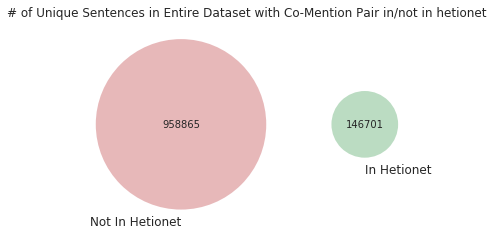

In [26]:
ids =filtered_total_candidates_df.query("hetionet==1").sentence_id.values
venn2(
    [
        set(filtered_total_candidates_df.query("hetionet==0&sentence_id not in @ids").sentence_id),
        set(filtered_total_candidates_df.query("hetionet==1").sentence_id)
    ], set_labels=["Not In Hetionet", "In Hetionet"])
plt.title("# of Unique Sentences in Entire Dataset with Co-Mention Pair in/not in hetionet")

# Co-occuring Mentions Sentence Stats

This next block contains a visualization about the number of mentions a sentence may contain.

Text(0.5,1,'Mention Distribution of Entire Dataset')

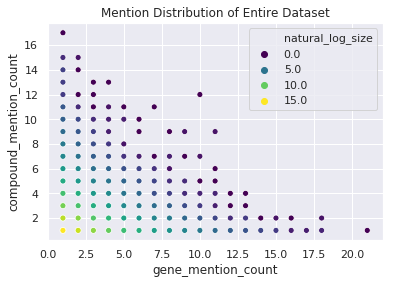

In [27]:
ax = sns.scatterplot(
    x="gene_mention_count", 
    y="compound_mention_count", 
    data=
    (
        filtered_total_candidates_df
        .drop_duplicates("sentence_id")
        .groupby(["gene_mention_count", "compound_mention_count"]).size()
        .reset_index()
        .rename(index=str, columns={0:"size"})
        .assign(natural_log_size= lambda x: pd.np.log(x['size']))
    ),
    hue="natural_log_size",
    palette='viridis'
)
ax.set_title("Mention Distribution of Entire Dataset")

In the above graph every point is group of possible mention counts sentences could contain. For example one group has sentences containing one gene mention and one compound mention (indicated in the bottom left in yellow). Overall this graph is acceptable in terms of the spread between mentions; however, when getting ready to train the deep learning models one has to make sure the algorithm can detect which co-mention pair the candidate is referring to.

# Subsampled Set Distributions

Take a look at the stratification for each train/dev/test set.

## Training Set

Here the training set covers majority of the characterisitics are the entire dataset. This isn't surprising because a stratified sort was used to allocate candidates.

Text(0.5,1,'Distribution of Sentences in Entire Training Set')

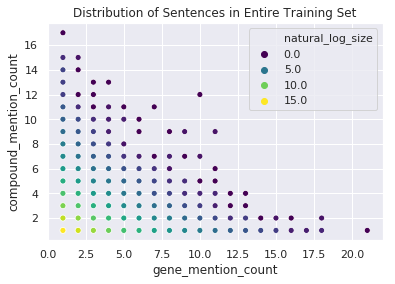

In [28]:
ax = sns.scatterplot(
    x="gene_mention_count", 
    y="compound_mention_count", 
    data=
    (
        filtered_total_candidates_df
        .query("split==6")
        .drop_duplicates("sentence_id")
        .groupby(["gene_mention_count", "compound_mention_count"]).size()
        .reset_index()
        .rename(index=str, columns={0:"size"})
        .assign(natural_log_size= lambda x: pd.np.log(x['size']))
    ),
    hue="natural_log_size",
    palette='viridis'
)
ax.set_title("Distribution of Sentences in Entire Training Set")

## Dev Set

This block contains information on the development set (aka tuning set).

Text(0.5,1,'Sentence Distribution of Total Dev Dataset')

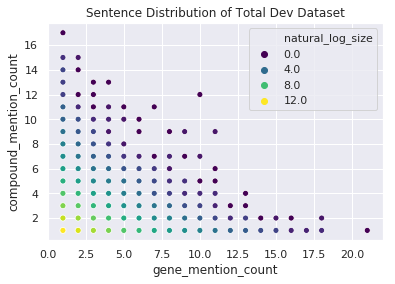

In [29]:
ax = sns.scatterplot(
    x="gene_mention_count", 
    y="compound_mention_count", 
    data=
    (
        filtered_total_candidates_df
        .query("split==7")
        .drop_duplicates("sentence_id")
        .groupby(["gene_mention_count", "compound_mention_count"]).size()
        .reset_index()
        .rename(index=str, columns={0:"size"})
        .assign(natural_log_size= lambda x: pd.np.log(x['size']))
    ),
    hue="natural_log_size",
    palette='viridis'
)
ax.set_title("Sentence Distribution of Total Dev Dataset")

/home/danich1/anaconda2/envs/snorkeling/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


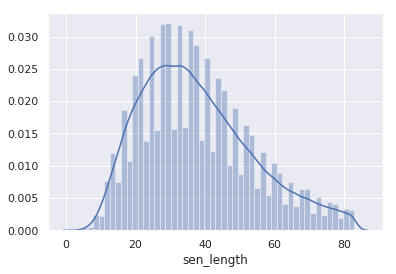

In [30]:
sns.distplot(filtered_total_candidates_df.query("split==7")["sen_length"], rug=False)

## Test Set

This block contains information on the test set.

Text(0.5,1,'Sentence Distribution of Total Test Dataset')

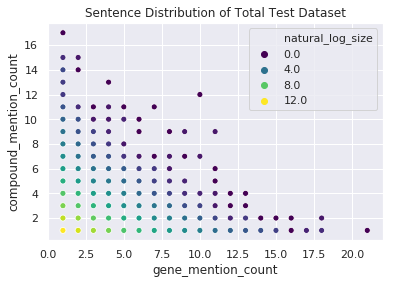

In [31]:
ax = sns.scatterplot(
    x="gene_mention_count", 
    y="compound_mention_count", 
    data=
    (
        filtered_total_candidates_df
        .query("split==8")
        .drop_duplicates("sentence_id")
        .groupby(["gene_mention_count", "compound_mention_count"]).size()
        .reset_index()
        .rename(index=str, columns={0:"size"})
        .assign(natural_log_size= lambda x: pd.np.log(x['size']))
    ),
    hue="natural_log_size",
    palette='viridis'
)
ax.set_title("Sentence Distribution of Total Test Dataset")

/home/danich1/anaconda2/envs/snorkeling/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


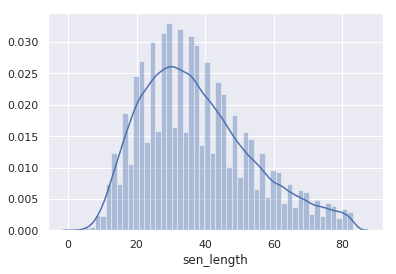

In [32]:
sns.distplot(filtered_total_candidates_df.query("split==8")["sen_length"], rug=False)

In conclusion, the optimal cutoff point in this case would be: **84** tokens/words or smaller depending on algorithm performance. Another important lesson is to analyze one's dataset before undergoing the journey of training a deep learning model. Sentence length is an important factor, when it comes to filtering out the dataset. If ignored, a significant amount of problems will arise. For example, when training a long short term memory network (LSTM), sequence length dictates how many steps the LSTM needs to traverse in order to ultimately calculate the probability of a sentence mentioning a relationship. If the LSTM were to be fed a sentence that contains 834 words, then the network has 834 steps to parse through. This takes a significant amount of time (~20 hours+). Plus during backpropogation, the gradient will become very small that the network cannot learn anything useful ([Backpropogation through time](https://en.wikipedia.org/wiki/Backpropagation_through_time)). 